# Module 4B: Probability, Threshold, and Prevalence (Interactive)

This notebook shows, visually, how an AI model turns probabilities into class decisions.

## Learning goals
1. See how changing the **decision threshold** changes classification.
2. See how this affects **TP, TN, FP, FN**.
3. See how prevalence changes what ROC-AUC and PR-AUC tell you.
4. See why, with the same sensitivity/specificity, changing prevalence changes PPV (precision).


## Big Picture First

Medical AI classification pipeline:

`Model score (0 to 1)` -> `Threshold` -> `Predicted class` -> `Confusion matrix` -> `Clinical metrics`

Use the sliders below to control each step and observe what changes.


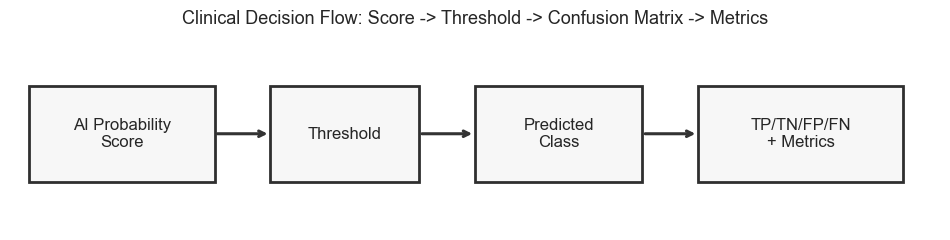

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score
from IPython.display import display

try:
    import ipywidgets as widgets
except Exception as exc:
    raise ImportError(
        "ipywidgets is required for this notebook. In Colab, run: !pip install -q ipywidgets"
    ) from exc

plt.style.use('seaborn-v0_8-whitegrid')

COLORS = {
    "neg": "#4c78a8",
    "pos": "#e45756",
    "thr": "#f58518",
    "tp": "#54a24b",
    "tn": "#4c78a8",
    "fp": "#f58518",
    "fn": "#b279a2",
}


def draw_pipeline_overview():
    fig, ax = plt.subplots(figsize=(12, 2.5))
    ax.axis('off')

    boxes = [
        (0.02, 0.25, 0.20, 0.5, 'AI Probability\nScore'),
        (0.28, 0.25, 0.16, 0.5, 'Threshold'),
        (0.50, 0.25, 0.18, 0.5, 'Predicted\nClass'),
        (0.74, 0.25, 0.22, 0.5, 'TP/TN/FP/FN\n+ Metrics'),
    ]

    for x, y, w, h, text in boxes:
        rect = plt.Rectangle((x, y), w, h, ec='#2f2f2f', fc='#f7f7f7', lw=2, zorder=2)
        ax.add_patch(rect)
        ax.text(x + w / 2, y + h / 2, text, ha='center', va='center', fontsize=12)

    arrows = [(0.22, 0.50, 0.28, 0.50), (0.44, 0.50, 0.50, 0.50), (0.68, 0.50, 0.74, 0.50)]
    for x1, y1, x2, y2 in arrows:
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1), arrowprops=dict(arrowstyle='->', lw=2.2, color='#333333'))

    ax.set_title('Clinical Decision Flow: Score -> Threshold -> Confusion Matrix -> Metrics', fontsize=13, pad=10)
    plt.show()


draw_pipeline_overview()


## Section 1: Threshold Changes Classification (with TP/TN/FP/FN)

We simulate model probabilities for a binary task. Ground truth labels are known.

- `prevalence` controls how common the positive class is.
- `separation` controls how strong model discrimination is.
- `threshold` controls final class assignment.


In [2]:
def simulate_probabilities(n_samples=3000, prevalence=0.20, separation=0.45, seed=7):
    # Simulate y_true and model probabilities with controllable class separation.
    rng = np.random.default_rng(seed)

    y_true = (rng.random(n_samples) < prevalence).astype(int)

    # Separation controls class-conditional score means.
    separation = float(np.clip(separation, 0.05, 0.90))
    mean_pos = np.clip(0.50 + separation / 2.0, 0.02, 0.98)
    mean_neg = np.clip(0.50 - separation / 2.0, 0.02, 0.98)

    concentration = 14.0  # higher => less variance around means
    a_pos, b_pos = mean_pos * concentration, (1 - mean_pos) * concentration
    a_neg, b_neg = mean_neg * concentration, (1 - mean_neg) * concentration

    probs = np.empty(n_samples, dtype=float)
    pos_idx = y_true == 1
    neg_idx = ~pos_idx
    probs[pos_idx] = rng.beta(a_pos, b_pos, pos_idx.sum())
    probs[neg_idx] = rng.beta(a_neg, b_neg, neg_idx.sum())

    return y_true, probs


def confusion_counts(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)

    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    tn = int(np.sum((y_true == 0) & (y_pred == 0)))
    fp = int(np.sum((y_true == 0) & (y_pred == 1)))
    fn = int(np.sum((y_true == 1) & (y_pred == 0)))

    return tp, tn, fp, fn


def safe_div(num, den):
    return float(num / den) if den > 0 else np.nan


def metric_dict(tp, tn, fp, fn):
    sens = safe_div(tp, tp + fn)
    spec = safe_div(tn, tn + fp)
    ppv = safe_div(tp, tp + fp)
    npv = safe_div(tn, tn + fn)
    acc = safe_div(tp + tn, tp + tn + fp + fn)
    f1 = safe_div(2 * tp, 2 * tp + fp + fn)

    return {
        "Sensitivity": sens,
        "Specificity": spec,
        "Precision (PPV)": ppv,
        "NPV": npv,
        "Accuracy": acc,
        "F1": f1,
    }


def plot_confusion(ax, tp, tn, fp, fn, title='Confusion Matrix'):
    mat = np.array([[tn, fp], [fn, tp]], dtype=float)
    ax.imshow(mat, cmap='YlOrRd')
    ax.set_xticks([0, 1], ['Pred 0', 'Pred 1'])
    ax.set_yticks([0, 1], ['True 0', 'True 1'])
    ax.set_title(title)

    labels = np.array([['TN', 'FP'], ['FN', 'TP']])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{labels[i, j]}\n{int(mat[i, j])}", ha='center', va='center', fontsize=11)


def threshold_dashboard(threshold=0.50, prevalence=0.20, separation=0.45, n_samples=3000, seed=7):
    y_true, y_prob = simulate_probabilities(
        n_samples=n_samples,
        prevalence=prevalence,
        separation=separation,
        seed=seed,
    )

    tp, tn, fp, fn = confusion_counts(y_true, y_prob, threshold=threshold)
    metrics = metric_dict(tp, tn, fp, fn)

    fig = plt.figure(figsize=(16, 4.6))
    gs = fig.add_gridspec(1, 3, width_ratios=[1.6, 1.0, 1.4])

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    bins = np.linspace(0, 1, 31)
    ax1.hist(y_prob[y_true == 0], bins=bins, alpha=0.65, color=COLORS['neg'], label='True class: 0 (negative)')
    ax1.hist(y_prob[y_true == 1], bins=bins, alpha=0.65, color=COLORS['pos'], label='True class: 1 (positive)')
    ax1.axvline(threshold, color=COLORS['thr'], lw=2.5, linestyle='--', label=f'Threshold = {threshold:.2f}')
    ax1.set_title('Predicted Probability Distribution')
    ax1.set_xlabel('Model predicted probability')
    ax1.set_ylabel('Count')
    ax1.legend(loc='upper center', fontsize=9)

    plot_confusion(ax2, tp=tp, tn=tn, fp=fp, fn=fn, title='Ground Truth vs Prediction')

    metric_names = ['Sensitivity', 'Specificity', 'Precision (PPV)', 'NPV', 'Accuracy', 'F1']
    metric_vals = [metrics[k] for k in metric_names]
    ax3.barh(metric_names, metric_vals, color=['#54a24b', '#4c78a8', '#e45756', '#72b7b2', '#9d755d', '#b279a2'])
    ax3.set_xlim(0, 1)
    ax3.set_title('Key Metrics at Current Threshold')
    for i, v in enumerate(metric_vals):
        ax3.text(min(v + 0.02, 0.98), i, f"{v:.3f}" if np.isfinite(v) else 'nan', va='center', fontsize=10)

    fig.suptitle(
        f"Threshold={threshold:.2f} | Prevalence={prevalence:.2f} | Separation={separation:.2f} | N={n_samples}",
        fontsize=13,
        y=1.03,
    )
    plt.tight_layout()
    plt.show()

    summary = pd.DataFrame([
        {
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'Sensitivity': metrics['Sensitivity'],
            'Specificity': metrics['Specificity'],
            'PPV': metrics['Precision (PPV)'],
            'NPV': metrics['NPV'],
        }
    ])
    display(summary.round(4))


controls_1 = {
    'threshold': widgets.FloatSlider(value=0.50, min=0.01, max=0.99, step=0.01, description='Threshold', readout_format='.2f'),
    'prevalence': widgets.FloatSlider(value=0.20, min=0.01, max=0.80, step=0.01, description='Prevalence', readout_format='.2f'),
    'separation': widgets.FloatSlider(value=0.45, min=0.05, max=0.90, step=0.01, description='Separation', readout_format='.2f'),
    'n_samples': widgets.IntSlider(value=3000, min=500, max=12000, step=500, description='N samples'),
    'seed': widgets.IntSlider(value=7, min=0, max=100, step=1, description='Seed'),
}

ui_1 = widgets.VBox([
    widgets.HTML('<h4>Interactive Controls: Threshold and Classification</h4>'),
    controls_1['threshold'],
    controls_1['prevalence'],
    controls_1['separation'],
    controls_1['n_samples'],
    controls_1['seed'],
])

out_1 = widgets.interactive_output(threshold_dashboard, controls_1)
display(ui_1, out_1)


Output()

## Section 2: Skew Prevalence and Compare ROC vs PR

Here we keep model separation fixed and only change prevalence.

Observe:
1. ROC-AUC usually changes little with prevalence shifts.
2. PR-AUC and Precision are much more sensitive to prevalence.
3. For rare diseases, PR plots are often more clinically informative.


In [3]:
def prevalence_comparison(prevalence_a=0.05, prevalence_b=0.45, separation=0.45, n_samples=6000, seed=11):
    y_a, p_a = simulate_probabilities(n_samples=n_samples, prevalence=prevalence_a, separation=separation, seed=seed)
    y_b, p_b = simulate_probabilities(n_samples=n_samples, prevalence=prevalence_b, separation=separation, seed=seed + 1)

    roc_a = roc_auc_score(y_a, p_a)
    roc_b = roc_auc_score(y_b, p_b)
    ap_a = average_precision_score(y_a, p_a)
    ap_b = average_precision_score(y_b, p_b)

    fpr_a, tpr_a, _ = roc_curve(y_a, p_a)
    fpr_b, tpr_b, _ = roc_curve(y_b, p_b)

    prec_a, rec_a, _ = precision_recall_curve(y_a, p_a)
    prec_b, rec_b, _ = precision_recall_curve(y_b, p_b)

    fig, ax = plt.subplots(1, 2, figsize=(13, 5))

    ax[0].plot(fpr_a, tpr_a, color='#1f77b4', lw=2.2, label=f'Low prevalence={prevalence_a:.2f} | ROC-AUC={roc_a:.3f}')
    ax[0].plot(fpr_b, tpr_b, color='#d62728', lw=2.2, label=f'High prevalence={prevalence_b:.2f} | ROC-AUC={roc_b:.3f}')
    ax[0].plot([0, 1], [0, 1], '--', color='gray', lw=1)
    ax[0].set_title('ROC Curves')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].legend(loc='lower right', fontsize=9)

    ax[1].plot(rec_a, prec_a, color='#1f77b4', lw=2.2, label=f'Low prevalence={prevalence_a:.2f} | PR-AUC={ap_a:.3f}')
    ax[1].plot(rec_b, prec_b, color='#d62728', lw=2.2, label=f'High prevalence={prevalence_b:.2f} | PR-AUC={ap_b:.3f}')
    ax[1].axhline(prevalence_a, color='#1f77b4', linestyle='--', lw=1, alpha=0.6)
    ax[1].axhline(prevalence_b, color='#d62728', linestyle='--', lw=1, alpha=0.6)
    ax[1].set_title('Precision-Recall Curves')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].legend(loc='lower left', fontsize=9)

    fig.suptitle(
        f'Same model separation ({separation:.2f}), different prevalence',
        fontsize=13,
        y=1.02,
    )
    plt.tight_layout()
    plt.show()

    summary = pd.DataFrame([
        {'Scenario': f'Low prevalence ({prevalence_a:.2f})', 'ROC-AUC': roc_a, 'PR-AUC': ap_a},
        {'Scenario': f'High prevalence ({prevalence_b:.2f})', 'ROC-AUC': roc_b, 'PR-AUC': ap_b},
    ])
    display(summary.round(4))


controls_2 = {
    'prevalence_a': widgets.FloatSlider(value=0.05, min=0.01, max=0.60, step=0.01, description='Prev A', readout_format='.2f'),
    'prevalence_b': widgets.FloatSlider(value=0.45, min=0.01, max=0.90, step=0.01, description='Prev B', readout_format='.2f'),
    'separation': widgets.FloatSlider(value=0.45, min=0.05, max=0.90, step=0.01, description='Separation', readout_format='.2f'),
    'n_samples': widgets.IntSlider(value=6000, min=1000, max=20000, step=1000, description='N samples'),
    'seed': widgets.IntSlider(value=11, min=0, max=200, step=1, description='Seed'),
}

ui_2 = widgets.VBox([
    widgets.HTML('<h4>Interactive Controls: Prevalence Shift vs ROC and PR</h4>'),
    controls_2['prevalence_a'],
    controls_2['prevalence_b'],
    controls_2['separation'],
    controls_2['n_samples'],
    controls_2['seed'],
])

out_2 = widgets.interactive_output(prevalence_comparison, controls_2)
display(ui_2, out_2)


Output()

## Section 3: Same Sensitivity/Specificity, Different Prevalence -> Different PPV

Clinical reality: if sensitivity and specificity stay fixed, PPV still changes with prevalence.

\[
PPV = 
rac{Sensitivity 	imes Prevalence}{Sensitivity 	imes Prevalence + (1-Specificity) 	imes (1-Prevalence)}
\]

Use the sliders to verify this mathematically and visually.


In [4]:
def expected_counts_from_test_characteristics(n_patients, prevalence, sensitivity, specificity):
    pos = prevalence * n_patients
    neg = (1 - prevalence) * n_patients

    tp = sensitivity * pos
    fn = (1 - sensitivity) * pos
    tn = specificity * neg
    fp = (1 - specificity) * neg

    return tp, tn, fp, fn


def ppv_npv_from_params(prevalence, sensitivity, specificity):
    tp = sensitivity * prevalence
    fp = (1 - specificity) * (1 - prevalence)
    fn = (1 - sensitivity) * prevalence
    tn = specificity * (1 - prevalence)

    ppv = safe_div(tp, tp + fp)
    npv = safe_div(tn, tn + fn)
    return ppv, npv


def ppv_prevalence_dashboard(sensitivity=0.90, specificity=0.90, prevalence_a=0.05, prevalence_b=0.40, n_patients=10000):
    ppv_a, npv_a = ppv_npv_from_params(prevalence_a, sensitivity, specificity)
    ppv_b, npv_b = ppv_npv_from_params(prevalence_b, sensitivity, specificity)

    prev_grid = np.linspace(0.001, 0.999, 500)
    ppv_curve = []
    npv_curve = []
    for p in prev_grid:
        ppv_p, npv_p = ppv_npv_from_params(p, sensitivity, specificity)
        ppv_curve.append(ppv_p)
        npv_curve.append(npv_p)

    fig, ax = plt.subplots(1, 2, figsize=(13, 4.8))

    ax[0].plot(prev_grid, ppv_curve, color='#e45756', lw=2.4, label='PPV')
    ax[0].plot(prev_grid, npv_curve, color='#4c78a8', lw=2.4, label='NPV')
    ax[0].scatter([prevalence_a, prevalence_b], [ppv_a, ppv_b], color=['#1f77b4', '#d62728'], s=70, zorder=3)
    ax[0].set_xlabel('Prevalence')
    ax[0].set_ylabel('Predictive value')
    ax[0].set_title('Predictive Values vs Prevalence')
    ax[0].legend(loc='best')

    labels = ['Scenario A', 'Scenario B']
    x = np.arange(2)
    w = 0.35
    ax[1].bar(x - w / 2, [ppv_a, ppv_b], width=w, color='#e45756', label='PPV')
    ax[1].bar(x + w / 2, [npv_a, npv_b], width=w, color='#4c78a8', label='NPV')
    ax[1].set_xticks(x, labels)
    ax[1].set_ylim(0, 1)
    ax[1].set_title('Same Sens/Spec, Different Prevalence')
    ax[1].legend(loc='best')

    for i, val in enumerate([ppv_a, ppv_b]):
        ax[1].text(i - w / 2, min(val + 0.03, 0.98), f'{val:.3f}', ha='center', fontsize=10)
    for i, val in enumerate([npv_a, npv_b]):
        ax[1].text(i + w / 2, min(val + 0.03, 0.98), f'{val:.3f}', ha='center', fontsize=10)

    fig.suptitle(f'Sensitivity={sensitivity:.2f}, Specificity={specificity:.2f}', fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

    tp_a, tn_a, fp_a, fn_a = expected_counts_from_test_characteristics(
        n_patients=n_patients,
        prevalence=prevalence_a,
        sensitivity=sensitivity,
        specificity=specificity,
    )
    tp_b, tn_b, fp_b, fn_b = expected_counts_from_test_characteristics(
        n_patients=n_patients,
        prevalence=prevalence_b,
        sensitivity=sensitivity,
        specificity=specificity,
    )

    table = pd.DataFrame([
        {
            'Scenario': 'A',
            'Prevalence': prevalence_a,
            'TP': tp_a,
            'FP': fp_a,
            'TN': tn_a,
            'FN': fn_a,
            'PPV': ppv_a,
            'NPV': npv_a,
        },
        {
            'Scenario': 'B',
            'Prevalence': prevalence_b,
            'TP': tp_b,
            'FP': fp_b,
            'TN': tn_b,
            'FN': fn_b,
            'PPV': ppv_b,
            'NPV': npv_b,
        },
    ])

    display(table.round(3))


controls_3 = {
    'sensitivity': widgets.FloatSlider(value=0.90, min=0.50, max=0.99, step=0.01, description='Sensitivity', readout_format='.2f'),
    'specificity': widgets.FloatSlider(value=0.90, min=0.50, max=0.99, step=0.01, description='Specificity', readout_format='.2f'),
    'prevalence_a': widgets.FloatSlider(value=0.05, min=0.01, max=0.80, step=0.01, description='Prev A', readout_format='.2f'),
    'prevalence_b': widgets.FloatSlider(value=0.40, min=0.01, max=0.95, step=0.01, description='Prev B', readout_format='.2f'),
    'n_patients': widgets.IntSlider(value=10000, min=1000, max=50000, step=1000, description='Patients'),
}

ui_3 = widgets.VBox([
    widgets.HTML('<h4>Interactive Controls: PPV Shift with Prevalence</h4>'),
    controls_3['sensitivity'],
    controls_3['specificity'],
    controls_3['prevalence_a'],
    controls_3['prevalence_b'],
    controls_3['n_patients'],
])

out_3 = widgets.interactive_output(ppv_prevalence_dashboard, controls_3)
display(ui_3, out_3)


Output()

## Practical Takeaways

1. A model score is not a diagnosis. Clinical action starts after choosing a threshold.
2. TP/TN/FP/FN move when threshold changes, so policy and workload also change.
3. ROC can look stable across prevalence shifts; PR is often more informative for rare conditions.
4. Even with fixed sensitivity/specificity, PPV depends strongly on prevalence.
